In [28]:
import numpy as np
import cv2
from functions import *
import matplotlib.pyplot as plt

In [2]:
def e1(img):
    dx = np.diff(img.astype(np.int64),axis=1)
    dx = np.concatenate((dx,dx[:,-1].reshape(-1,1)),axis=1)
    dy = np.diff(img.astype(np.int64),axis=0)
    dy = np.concatenate((dy,dy[-1,:].reshape(1,-1)),axis=0)
    e1 = np.absolute(dx) + np.absolute(dy)
    return e1.astype(np.uint8)

In [3]:
def vert_seam(img_e1):
    dp = np.empty((img_e1.shape[0],img_e1.shape[1],2),dtype=np.int64)
    dp[0,:,0] = img_e1[0,:]
    dp[0,:,1] = 0
    for i in range(1,img_e1.shape[0]):
        for j in range(0,img_e1.shape[1]):
            dp[i,j,1] = np.argmin([dp[i-1,j,0],dp[i-1,j+1,0]]) if j == 0 else np.argmin([dp[i-1,j-1,0],dp[i-1,j,0]]) - 1 if j == img_e1.shape[1]-1 else np.argmin([dp[i-1,j-1,0],dp[i-1,j,0],dp[i-1,j,0]]) - 1
            dp[i,j,0] = img_e1[i,j] + dp[i-1,j+dp[i,j,1],0]
    l = np.argmin(dp[-1,:,0])
    seam_path = [(img_e1.shape[0]-1,l)]
    for i in range(img_e1.shape[0]-2,-1,-1):
        l = l+dp[i+1,l,1]
        seam_path = seam_path + [(i,l)]
    seam_path.reverse()
    return np.array(seam_path,dtype=np.int64)

In [4]:
def repeated_vert_seams(img_gray,n):
    v_seams = []
    img_copy = img_gray.copy()
    for i in range(n):
        img_energy = e1(img_copy)
        v_seams.append(vert_seam(img_energy))
        mask = np.ones(img_copy.shape,dtype=bool)
        mask[v_seams[-1][:,0],v_seams[-1][:,1]] = False
        img_copy = img_copy[mask].reshape(img_copy.shape[0],img_copy.shape[1]-1)
    return v_seams

In [5]:
def compose_vert_seams(v_seam1,v_seam2):
    compose = np.vectorize(lambda x,y : y+1 if x <= y else y)
    composed_seam = np.empty(v_seam2.shape,dtype=np.int64)
    composed_seam[:,0] = v_seam2[:,0]
    composed_seam[:,1] = compose(v_seam1[:,1],v_seam2[:,1])
    return composed_seam

In [6]:
def transform_vert_seams(v_seams):
    transformed_seams = [v_seams[0]]
    for v_seam in v_seams[1:]:
        temp_seam = v_seam
        for transformed_seam in transformed_seams[::-1]:
            temp_seam = compose_vert_seams(transformed_seam,temp_seam)
        transformed_seams.append(temp_seam)
    return transformed_seams

In [7]:
img = cv2.imread("../Test Images/2.jpg",1)
img_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
img_e1 = e1(img_gray)

In [17]:
img_f = np.fft.fft2(img_gray)
img_fshift = np.fft.fftshift(img_f)

In [47]:
img_fmag = np.log(np.abs(img_fshift))

In [50]:
img_fmag_scaled = ((img_fmag - img_fmag.min())/(img_fmag.max() - img_fmag.min())*255).astype(np.uint8)

In [51]:
show_img("Fourier",img_fmag_scaled,0)

27

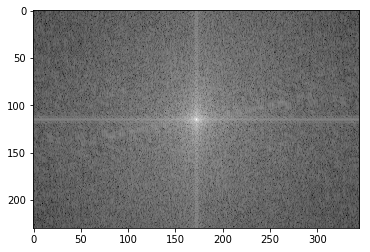

In [48]:
plt.imshow(img_fmag,cmap="gray")
plt.show()